In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [2]:
target_list = ['readmission', 'mortality', 'los>3day', 'los>7day', 'dx_depth1_unique']

targets_noRead = ['mortality', 'los>3day', 'los>7day', 'dx_depth1_unique']


fewshot_data = pd.read_csv('~/Desktop/finished_runs/fewshot_done.csv')
fewshot_data = fewshot_data[fewshot_data['State']=='finished']

### Just to be very, very clear, these are the numbers used below as the eicu-->eicu, mimic-->mimic baseline
## From meeting slides 3-7 of 20210206 meeting

# eicu = train on eicu, test on eicu (eicu-->eicu); mimic = mimic-->mimic
BCBERT_all_testAUPRC = pd.DataFrame([[0.203, 0.048],
                                    [0.206, 0.443],
                                    [0.702, 0.852],
                                    [0.474, 0.833],
                                    [0.521, 0.749]], columns=['eicu','mimic'], index=target_list)
singleRNN_all_testAUPRC = pd.DataFrame([[0.221, 0.051],
                                    [0.187, 0.402],
                                    [0.660, 0.844],
                                    [0.400, 0.808],
                                    [0.501, 0.751]], columns=['eicu','mimic'], index=target_list)

print('BCBERT_all_testAUPRC \n', BCBERT_all_testAUPRC, '\n\n')

print('singleRNN_all_testAUPRC \n', singleRNN_all_testAUPRC)

BCBERT_all_testAUPRC 
                    eicu  mimic
readmission       0.203  0.048
mortality         0.206  0.443
los>3day          0.702  0.852
los>7day          0.474  0.833
dx_depth1_unique  0.521  0.749 


singleRNN_all_testAUPRC 
                    eicu  mimic
readmission       0.221  0.051
mortality         0.187  0.402
los>3day          0.660  0.844
los>7day          0.400  0.808
dx_depth1_unique  0.501  0.751


In [3]:
# Missing 10 seeds!
fewshot_data[(fewshot_data['target']=='mortality')&(fewshot_data['test_file']=='eicu')&
            (fewshot_data['few_shot']==0.3)].loc[:,['bert_induced','bert_model','few_shot','item','seed',
                                     'test_file','target','test_auprc']]

,bert_induced,bert_model,few_shot,item,seed,test_file,target,test_auprc
437,False,bio_clinical_bert,0.3,all,2029,eicu,mortality,0.122602
450,False,bio_clinical_bert,0.3,all,2028,eicu,mortality,0.159005
468,False,bio_clinical_bert,0.3,all,2027,eicu,mortality,0.119828
481,False,bio_clinical_bert,0.3,all,2026,eicu,mortality,0.130834
498,False,bio_clinical_bert,0.3,all,2025,eicu,mortality,0.178808
517,False,bio_clinical_bert,0.3,all,2024,eicu,mortality,0.157321
539,False,bio_clinical_bert,0.3,all,2023,eicu,mortality,0.162097
573,False,bio_clinical_bert,0.3,all,2022,eicu,mortality,0.113162
584,False,bio_clinical_bert,0.3,all,2021,eicu,mortality,0.121354
618,False,bio_clinical_bert,0.3,all,2020,eicu,mortality,0.161308


In [4]:
def datasize_fewshot_plot(result_file:pd.DataFrame, benchmark_descEmb:pd.DataFrame, benchmark_codeEmb:pd.DataFrame,
                          source_file, item, target, subplot_index):
    
    result_file = result_file.loc[:,['bert_induced','bert_model','few_shot','item','seed',
                                     'test_file','target','test_auprc']]

    # Assert error if one seed is present more than once per cell
    groupcheck = result_file.groupby(['test_file','target','item','few_shot','bert_induced','seed']).agg('count')
    assert not (any([any(groupcheck[i]>1) for i in groupcheck.columns])), 'Overlapping seeds'
    # Assert error if more than 10 seeds for single category 
    groupcheck = result_file.groupby(['test_file','target','item','few_shot','bert_induced']).agg('count')
    assert not (any([any(groupcheck[i]>10) for i in groupcheck.columns])), 'At least one cell would aggregate >10 seeds'    
    
    result_file = result_file.drop('seed', axis=1)
    grouped = result_file.groupby(['test_file','target','item','few_shot','bert_induced']).agg(['mean','std'])
    sample = grouped.loc[(source_file, target, item)].reset_index(level=['few_shot','bert_induced'], col_level=1)
    
    #if test_file=='both':
    #    sample = sample.drop('test_auprc', axis=1)
    #else:
    #    sample = sample.drop(['eicu_test_auprc','mimic_test_auprc'],axis=1)

    # Messy, but the more elegant approach was giving me trouble
    BERT = sample.loc[sample.iloc[:,1]] # sample.iloc[:,1] is the "bert_induced" index...

    idx = pd.IndexSlice
    BERTfewshot_levels = BERT.loc[:,idx[:, 'few_shot']].values.flatten()
    BERTmeans = BERT.loc[:,('test_auprc','mean')].values
    BERTupper_sd = BERTmeans + BERT.loc[:,('test_auprc','std')].values
    BERTlower_sd = BERTmeans - BERT.loc[:,('test_auprc','std')].values

    RNN = sample.loc[~sample.iloc[:,1]] # i.e. keep if bert_induced == False
    RNNfewshot_levels = RNN.loc[:,idx[:, 'few_shot']].values.flatten()
    RNNmeans = RNN.loc[:,('test_auprc','mean')].values
    RNNupper_sd = RNNmeans + RNN.loc[:,('test_auprc','std')].values
    RNNlower_sd = RNNmeans - RNN.loc[:,('test_auprc','std')].values

    # Before plotting, a couple of aesthetic things to address
    target_dict = {'readmission':'Readmission', 'mortality':'Mortality', 'los>3day':'LOS > 3 Days',
                   'los>7day':'LOS > 7 Days', 'dx_depth1_unique':'Diagnosis'}
    source_dict = {'eicu':'eICU', 'mimic':'MIMIC-III'}
    
    # Plot
    ax = fig.add_subplot(2, 3, subplot_index)
    
    # BERT induced
    ax.plot(BERTfewshot_levels, BERTmeans, color='crimson', label='DescEmb')
    plt.fill_between(BERTfewshot_levels, BERTupper_sd, BERTlower_sd, facecolor='pink', alpha=0.5)

    # singleRNN
    ax.plot(RNNfewshot_levels, RNNmeans, color='darkblue', label='CodeEmb')
    plt.fill_between(RNNfewshot_levels, RNNupper_sd, RNNlower_sd, facecolor='lightsteelblue', alpha=0.5)
    
    # Benchmark
    ax.axhline(y=benchmark_descEmb.loc[target,source_file], color='g', 
               label='BioClinical BERT {}-->{}'.format(source_dict[source_file],source_dict[source_file]))
    ax.axhline(y=benchmark_codeEmb.loc[target,source_file], color='purple', 
               label='CodeEmb {}-->{}'.format(source_dict[source_file],source_dict[source_file]))

    ax.set_xticks(BERTfewshot_levels, minor=False)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xlabel('Proportion of Target Dataset')
    ax.set_ylabel('Test Set AUPRC')
    ax.grid(which='major', axis='x')
    ax.grid(which='major', axis='y')
    plt.title('{} Prediction'.format(target_dict[target]))

    if subplot_index == 5:
        plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1))

    fig.suptitle('Fewshot Learning in {} EHR'.format(source_dict[source_file]), fontsize=25)



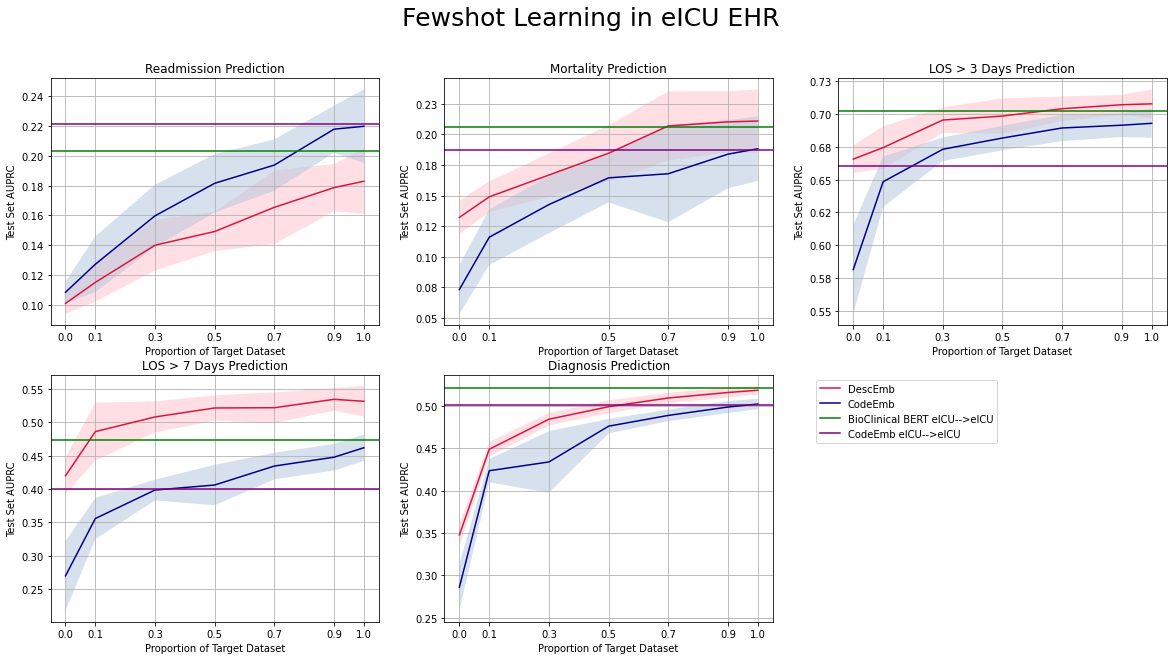

In [5]:
# For targets_noRead
#fig = plt.figure(figsize=(20*.75, 15*.75))

# For target_list
fig = plt.figure(figsize=(20, 10))


for subplot, target in enumerate(target_list): 
    datasize_fewshot_plot(fewshot_data, BCBERT_all_testAUPRC, singleRNN_all_testAUPRC,
                          'eicu', 'all', target, subplot_index=subplot+1)
    


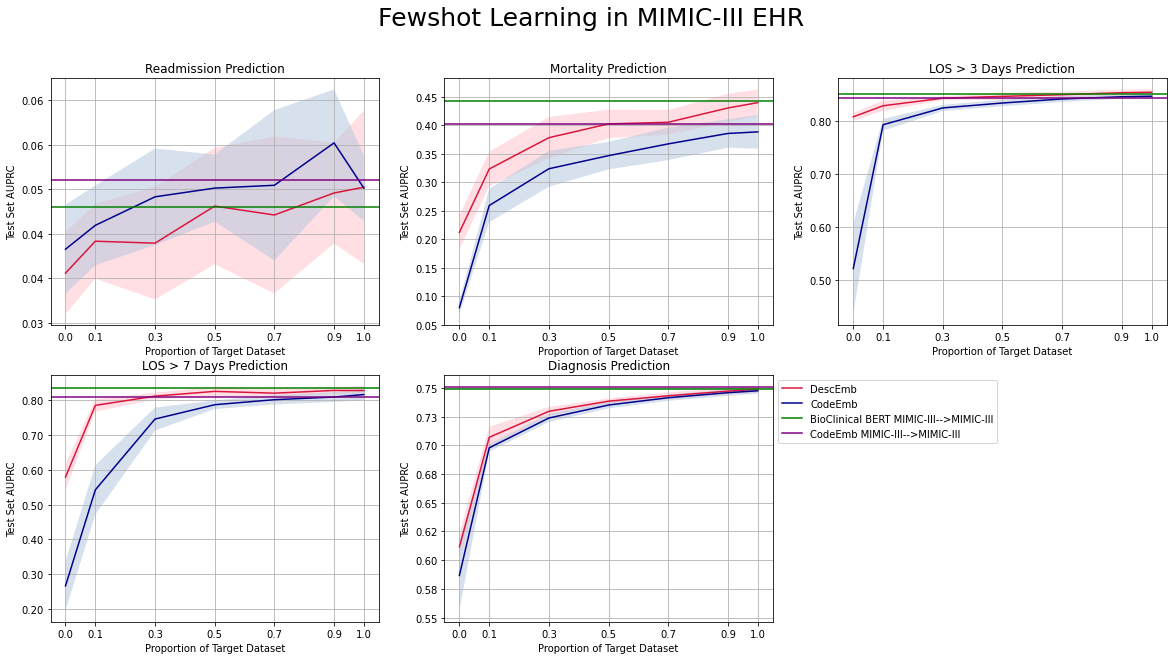

In [6]:
# For targets_noRead
#fig = plt.figure(figsize=(20*.75, 15*.75))

# For target_list
fig = plt.figure(figsize=(20, 10))

for subplot, target in enumerate(target_list): 
    datasize_fewshot_plot(fewshot_data, BCBERT_all_testAUPRC, singleRNN_all_testAUPRC,
                          'mimic', 'all', target, subplot_index=subplot+1)